# 🔴 Tarea:

## Obtener los embeddings de cada documento con algún modelo tipo BERT y clusterizarlos.

**1. Carga y pre-procesamiento de datos**

In [1]:
# Librerías necesarias
from sklearn.datasets import fetch_20newsgroups
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Descargar recursos necesarios para preprocesamiento
nltk.download('punkt')
nltk.download('stopwords')

# Definir las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Cargar el dataset
all_data = fetch_20newsgroups(
    subset='all',
    remove=('headers', 'footers', 'quotes'),
    categories=['sci.space', 'rec.sport.baseball', 'sci.med'],  # Categorías relevantes
    random_state=642
)

# Datos y etiquetas
X_raw = all_data.data
y = all_data.target

# Preprocesamiento: limpieza y eliminación de stopwords
def preprocess_text(text):
    # Eliminar números y caracteres no alfanuméricos
    text = re.sub(r'\d+', ' ', text)  # Remover números
    text = re.sub(r'[^\w\s]', '', text)  # Remover puntuación
    # Tokenizar y eliminar stopwords
    tokenized_words = [word.lower() for word in word_tokenize(text) if word.lower() not in stop_words and word.isalnum()]
    return ' '.join(tokenized_words)

# Aplicar preprocesamiento
docs = [preprocess_text(doc) for doc in X_raw]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcbar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcbar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**2. Generación de embeddings**

In [2]:
# Modelo preentrenado Electra
MODEL_NAME = "google/electra-small-discriminator"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Asegurar que se use GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Función para generar embeddings
def generate_embeddings(documents, tokenizer, model, max_length=128, batch_size=16):
    """
    Genera embeddings para una lista de documentos.
    :param documents: Lista de textos.
    :param tokenizer: Tokenizador preentrenado.
    :param model: Modelo preentrenado.
    :param max_length: Longitud máxima de los tokens.
    :param batch_size: Tamaño del lote para procesamiento por lotes.
    :return: Tensor con los embeddings generados.
    """
    model.eval()  # Modo evaluación
    embeddings = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(documents), batch_size), desc="Generando Embeddings"):
            batch = documents[i:i + batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
            outputs = model(**inputs)
            # Usar la representación del token [CLS] para embeddings
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu()
            embeddings.append(cls_embeddings)
    
    return torch.cat(embeddings)

# Generar embeddings
print("Generando embeddings...")
embeddings = generate_embeddings(docs, tokenizer, model)

# Confirmar la forma de los embeddings
print(f"Forma de los embeddings: {embeddings.shape}")


Generando embeddings...


Generando Embeddings: 100%|██████████| 186/186 [00:05<00:00, 37.12it/s]

Forma de los embeddings: torch.Size([2971, 256])


**3. Reducción de dimensionalidad con UMAP**

Reduciendo dimensionalidad con UMAP...


c:\Users\jcbar\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Forma de los embeddings reducidos: (2971, 2)


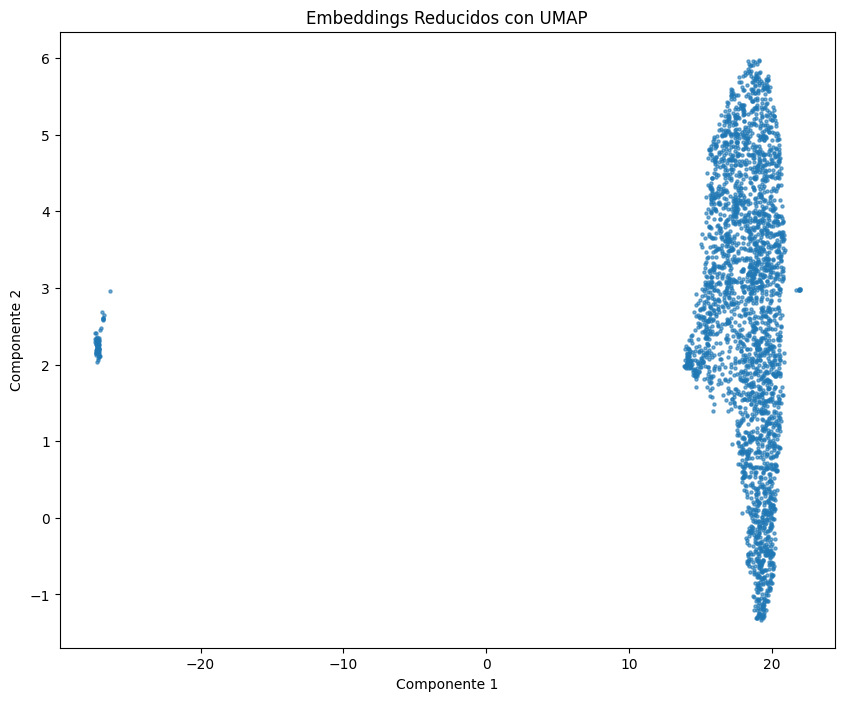

In [3]:
import umap
import matplotlib.pyplot as plt

# Configuración de UMAP
umap_model = umap.UMAP(
    n_neighbors=50,       # Número de vecinos cercanos utilizados para definir la estructura local
    n_components=2,       # Reducir a 2 dimensiones para visualización
    metric='cosine',      # Métrica para medir similitud
    min_dist=0.1,
    random_state=42       # Asegura reproducibilidad
)

# Reducir dimensionalidad de los embeddings
print("Reduciendo dimensionalidad con UMAP...")
reduced_embeddings = umap_model.fit_transform(embeddings)

# Verificar forma de los embeddings reducidos
print(f"Forma de los embeddings reducidos: {reduced_embeddings.shape}")

# Visualizar los embeddings reducidos
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, alpha=0.6)
plt.title("Embeddings Reducidos con UMAP")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

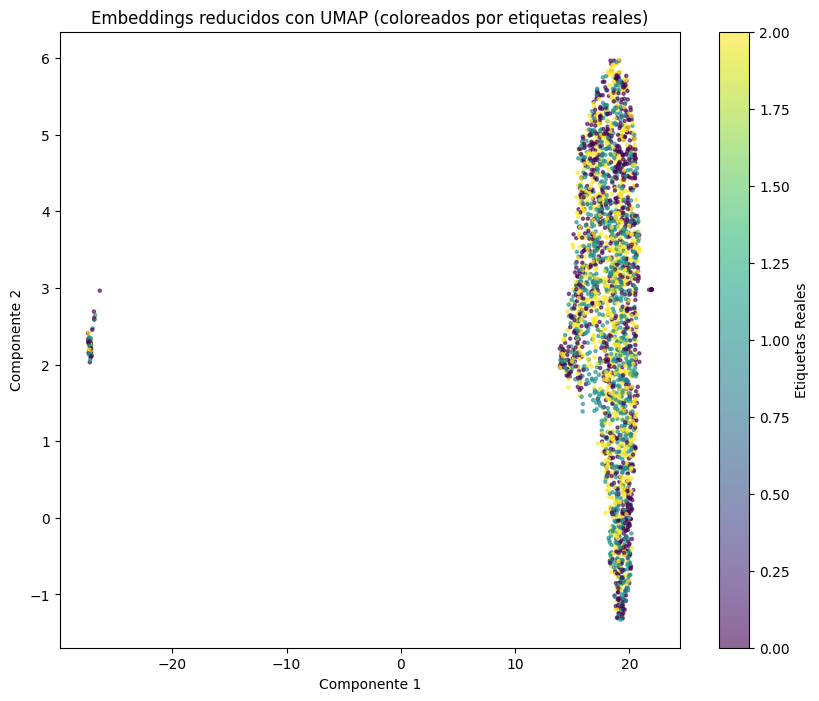

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Crear un gráfico de dispersión coloreado por las etiquetas reales
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_embeddings[:, 0],  # Componente 1 de UMAP
    reduced_embeddings[:, 1],  # Componente 2 de UMAP
    c=y,  # Colorear por las etiquetas reales
    s=5,  # Tamaño de los puntos
    alpha=0.6  # Transparencia
)
plt.colorbar(scatter, label='Etiquetas Reales')  # Barra de color para las etiquetas
plt.title("Embeddings reducidos con UMAP (coloreados por etiquetas reales)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


UMAP no parece ser bueno separando las estructuras globales/locales que conforman a los datos de los distintos tópicos.

**4. Clusterización**

In [5]:
#pip install hdbscan

In [6]:
#import hdbscan
#import numpy as np
#import matplotlib.pyplot as plt
#
## Configuración del modelo HDBSCAN
#hdbscan_model = hdbscan.HDBSCAN(
#    min_cluster_size=30,          # Tamaño mínimo de un cluster
#    metric='euclidean',           # Métrica utilizada
#    cluster_selection_method='eom',  # Método para seleccionar clusters
#    prediction_data=True          # Permitir predicción de nuevos datos
#)
#
## Aplicar HDBSCAN a los embeddings reducidos
#print("Aplicando HDBSCAN para la clusterización...")
#clusters = hdbscan_model.fit_predict(reduced_embeddings)
#
## Verificar resultados de la clusterización
#num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
#num_outliers = sum(clusters == -1)
#print(f"Número de clusters encontrados: {num_clusters}")
#print(f"Número de puntos clasificados como outliers: {num_outliers}")
#
## Visualización de los clusters
#plt.figure(figsize=(10, 8))
#unique_clusters = set(clusters)
#colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]
#
#for cluster, color in zip(unique_clusters, colors):
#    if cluster == -1:  # Outliers
#        color = [0.5, 0.5, 0.5, 0.5]  # Color gris para outliers
#    mask = clusters == cluster
#    plt.scatter(
#        reduced_embeddings[mask, 0],
#        reduced_embeddings[mask, 1],
#        c=[color],
#        label=f'Cluster {cluster}' if cluster != -1 else 'Outliers',
#        s=5,
#        alpha=0.6
#    )
#
#plt.title("Clusters Identificados por HDBSCAN")
#plt.xlabel("Componente 1")
#plt.ylabel("Componente 2")
#plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#plt.show()
#
#

HDBSCAN solo identifica 2 clusters.

Aplicando KMeans para la clusterización...
Número de clusters encontrados: 3


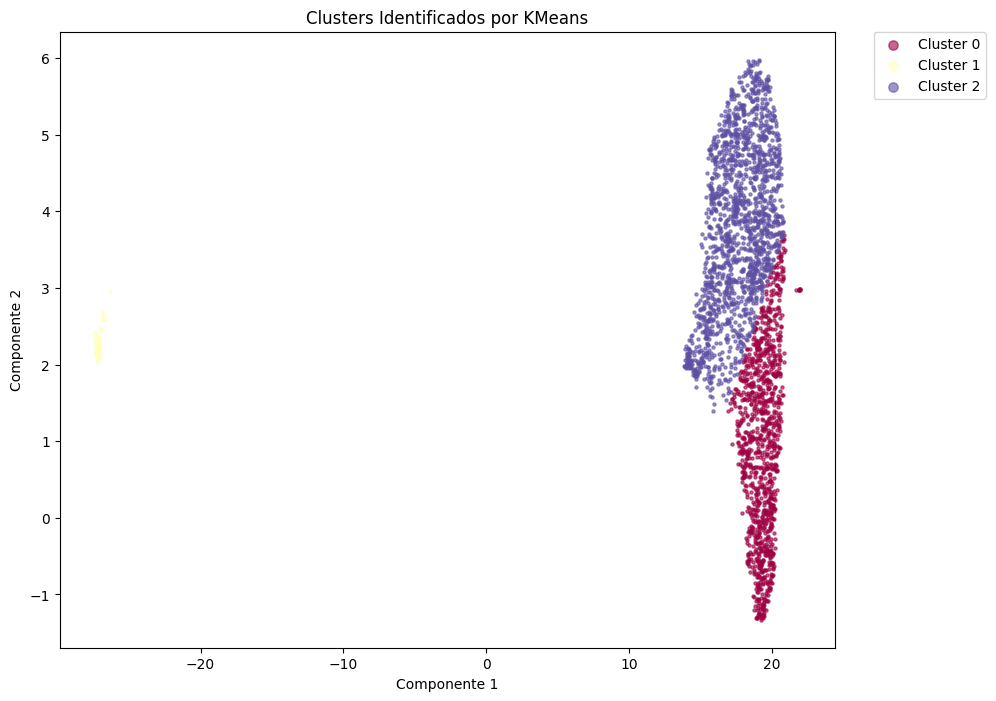

In [8]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Configuración del modelo KMeans
num_clusters = 3  # Número de clusters conocidos (3 tópicos)
kmeans_model = KMeans(
    n_clusters=num_clusters,  # Número de clusters
    random_state=42          # Para reproducibilidad
)

# Aplicar KMeans a los embeddings reducidos
print("Aplicando KMeans para la clusterización...")
clusters = kmeans_model.fit_predict(reduced_embeddings)

# Verificar resultados de la clusterización
print(f"Número de clusters encontrados: {num_clusters}")

# Visualización de los clusters
plt.figure(figsize=(10, 8))
unique_clusters = np.unique(clusters)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]

for cluster, color in zip(unique_clusters, colors):
    mask = clusters == cluster
    plt.scatter(
        reduced_embeddings[mask, 0],
        reduced_embeddings[mask, 1],
        c=[color],
        label=f'Cluster {cluster}',
        s=5,
        alpha=0.6
    )

plt.title("Clusters Identificados por KMeans")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


**5. Inspección de resultados por medio de nubes de palabras**

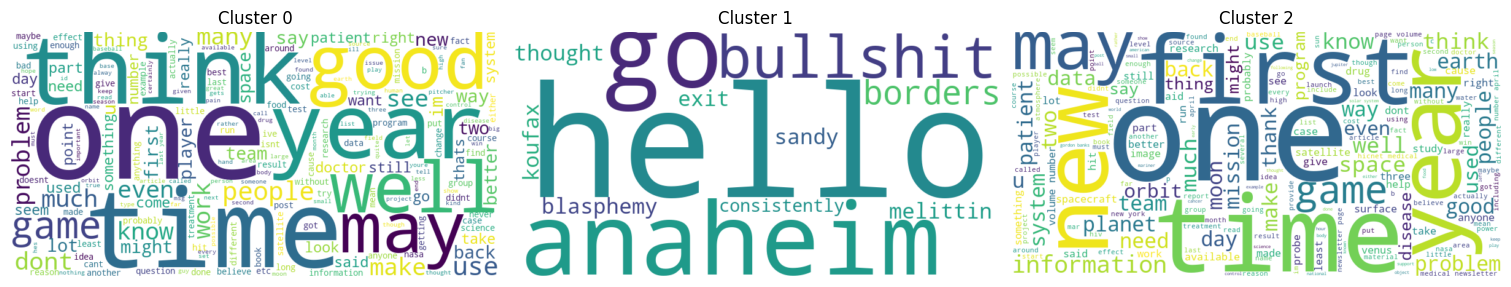

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear un diccionario para almacenar los documentos por cluster
cluster_docs = {cluster: [] for cluster in set(clusters) if cluster != -1}

# Asociar documentos con sus clusters
for i, cluster in enumerate(clusters):
    if cluster != -1:  # Excluir outliers
        cluster_docs[cluster].append(docs[i])

# Visualizar las nubes de palabras para cada cluster
num_clusters = len(cluster_docs)
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 5), constrained_layout=True)

for ax, (cluster, documents) in zip(axes, cluster_docs.items()):
    # Combinar todos los documentos del cluster
    text = " ".join(documents)
    
    # Generar la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    
    # Configurar el subplot
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Cluster {cluster}")

plt.show()



**6. Evaluación de rendimiento**

In [10]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

# Evaluar el rendimiento del clustering
ami_score = adjusted_mutual_info_score(y, clusters)
ari_score = adjusted_rand_score(y, clusters)

# Imprimir las métricas
print(f"AMI (Adjusted Mutual Information Score): {ami_score}")
print(f"ARI (Adjusted Rand Index): {ari_score}")


AMI (Adjusted Mutual Information Score): 0.0014687361786908774
ARI (Adjusted Rand Index): 0.0015409307713837848


## ¿Se mejoran los rendimientos?

No. En realidad el rendimiento empeoró. Probablemente se debe a que UMAP no es capaz de identificar y separar la estructura global/local que de los datos que conforman a cada uno de los tópicos. 